In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_swiss_roll

# Part 1: Score matching

# 1-1 load dataset


Text(0.5, 1.0, 'Original Samples')

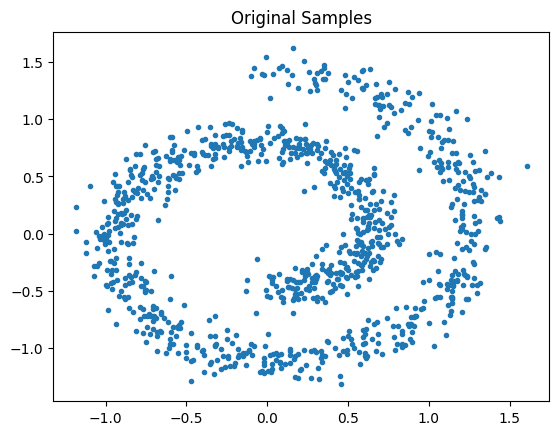

In [2]:
# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

# show the samples
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')
plt.title('Original Samples')

In [3]:
xtns.shape

torch.Size([1000, 2])

# 1-2 Neural Network for: $\mathbf{s_\theta}(\mathbf{x})$

In [6]:
# score_network takes input of 2 dimension and returns the output of the same size
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

# 1-3 Score Matching


We will implement the loss function below:
$$\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{x})\right\rVert^2 + \mathrm{tr}\left(\nabla_\mathbf{x} \mathbf{s_\theta}(\mathbf{x})\right)\right].
\end{equation}$$

In [1]:
!pip install functorch

In [4]:
from functorch import jacrev, vmap


def calc_loss(score_net: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_net(x)  # score: (batch_size, 2)
    jacobian = vmap(jacrev(score_net))(x)
    score_loss_1 = 0.5 * (torch.norm(score, dim=1) ** 2)
    score_loss_2 = jacobian.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)

    return torch.mean(score_loss_1 + score_loss_2)


# 1-4 Training

In [9]:
# start the training loop
import time
optim = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size = 32, shuffle=True)
t0 = time.time()
train_loss = []
for i_epoch in range(5000):
    total_loss = 0
    for data, in dloader:
        # print(data)

        optim.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        optim.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 250 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")
    train_loss = np.append(train_loss ,loss.item())


/usr/local/lib/python3.11/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/usr/local/lib/python3.11/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


0 (0.1910417079925537s): -0.06625513035058975
250 (38.52689456939697s): -12.71022306060791
500 (74.14912152290344s): -25.279935485839843
750 (110.61750984191895s): -41.73975857543945
1000 (148.1496913433075s): -47.18355456542969
1250 (185.7546272277832s): -49.603163513183596
1500 (226.69789338111877s): -51.85304537963867
1750 (265.9699032306671s): -53.638580078125
2000 (307.6747238636017s): -55.52883245849609
2250 (348.4525158405304s): -57.29202136230469
2500 (389.82462310791016s): -58.011921325683595
2750 (433.3823688030243s): -60.40412341308594
3000 (475.56463146209717s): -65.18929034423829
3250 (516.8690013885498s): -67.1581196899414
3500 (558.5602388381958s): -69.16638949584961
3750 (599.3455076217651s): -72.72421026611327
4000 (639.6797695159912s): -72.70875109863282
4250 (680.450314283371s): -74.54034075927734
4500 (720.89976811409s): -82.37425648498535
4750 (761.3224856853485s): -83.00496002197265


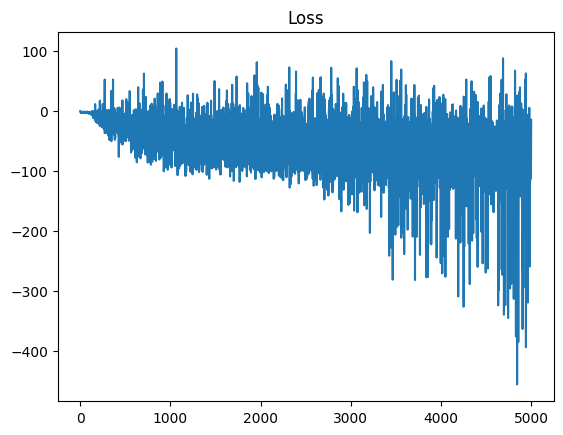

In [10]:
plt.plot(train_loss)
plt.title('Loss')
plt.show()

# 1-5 Generation

Once the neural network is trained, we can generate the samples using Langevin dynamics.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \varepsilon \nabla_\mathbf{x}\mathrm{log}\ p(\mathbf{x}) + \sqrt{2\varepsilon} \mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

In [11]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    new_x = torch.rand(nsamples, 2)

    for i in range(nsteps):
      draw = torch.randn_like(new_x)
      new_x = new_x + (eps * score_net(new_x)) +  ((2 * eps) ** 0.5) * draw

    return new_x


with torch.no_grad():
  samples = generate_samples(score_network, 1000)


Text(0.5, 1.0, 'Generated samples using Langevin dynamics')

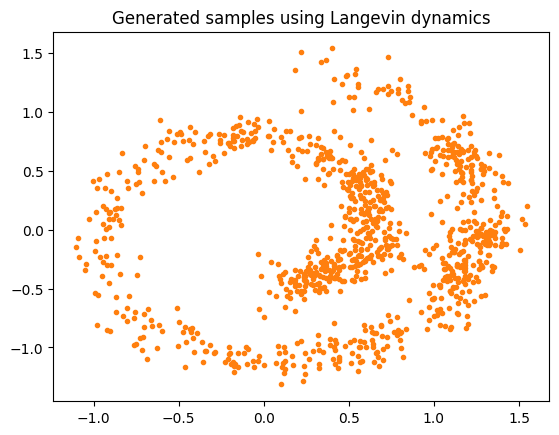

In [12]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')
plt.title('Generated samples using Langevin dynamics')

# Part 2: Denoising Score matching

# 2-1 Noise conditional Neural Network

Now we use a neural network to learn the score function. This is just a simple multi-layer perceptron with LogSigmoid activation function. In contrast to the previous part, the neural network here takes n+1 inputs and produces n outputs. The additional 1 input is for the noise in $t_i$

In [13]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network2 = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)


# 2-3 Score Matching

Now we implement the loss function below:
$$\begin{equation}
\mathcal{L}(\theta) = \frac{1}{L}\sum_{i=1}^{L}{λ(σ_i)}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{\tilde{x}}\sim q_{σ_i}(\mathbf{\tilde{x}|x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{\tilde{x}, σ_i}) - \nabla_\mathbf{\tilde{x}} \mathbf{log q_{σ_i}}(\mathbf{\tilde{x}|x})\right\rVert^2\right]
\end{equation}$$

$$\begin{equation}
=\frac{1}{L}\sum_{i=1}^{L}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})}\left[\frac{1}{2} \left\lVert\mathbf{\sigma_i s_\theta}(\mathbf{x+σ_iz, σ_i})+ z\right\rVert^2\right] + const.
\end{equation}$$


In [14]:
sigmas = torch.linspace(0.001, 0.04, steps=1000)
L = 1000


def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    # Sampling a mini-batch from noise scale indices
    sig_idx = torch.randperm(len(sigmas))[:len(x)]
    sig_samples = sigmas[sig_idx].view(-1,1)
    # Sampling a mini-batch from Gaussian noise
    z = torch.randn_like(x)
    perturbed_inputs = x + sig_samples * z
    net_input = torch.cat([perturbed_inputs, sig_samples],dim = 1)
    term_one = score_network2(net_input) * sig_samples
    loss = torch.mean(0.5 * (torch.norm(term_one + z, dim=1) ** 2))

    return loss

# 2-4 Training

In [15]:
# start the training loop
import time
optim = torch.optim.Adam(score_network2.parameters(), lr = 3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size = 256, shuffle=True)
t0 = time.time()
train_loss2 = []
for i_epoch in range(20000):
    total_loss = 0
    for data, in dloader:
        optim.zero_grad()

        # training step
        loss = calc_loss(score_network2, data)
        loss.backward()
        optim.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 1000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")
    train_loss2 = np.append(train_loss2 ,loss.item())

0 (0.025540828704833984s): 1.0225477390289306
1000 (14.861050367355347s): 0.9824135527610779
2000 (29.476930856704712s): 1.0306157846450805
3000 (44.631808042526245s): 1.022605863571167
4000 (59.70334529876709s): 0.9900577301979065
5000 (74.42632699012756s): 0.9781781911849976
6000 (89.13826203346252s): 1.0332569894790649
7000 (103.62627220153809s): 0.9696718459129333
8000 (118.51551580429077s): 0.9639902334213257
9000 (133.7667806148529s): 0.9643807916641235
10000 (150.22503280639648s): 1.057673791885376
11000 (167.04970002174377s): 0.9434098310470581
12000 (184.18205332756042s): 0.9922120218276977
13000 (202.39233326911926s): 0.9881768436431885
14000 (220.87627744674683s): 1.0108050279617309
15000 (240.32605719566345s): 0.9691362099647522
16000 (260.37706542015076s): 0.9644029569625855
17000 (280.37794756889343s): 0.9920754613876342
18000 (301.5088357925415s): 0.9296033682823182
19000 (323.40819001197815s): 0.9355053849220276


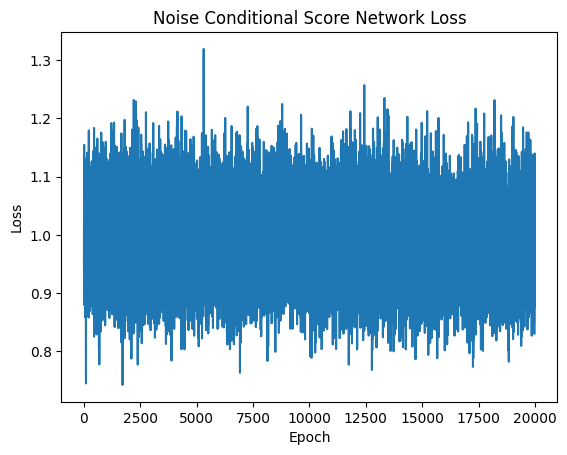

In [16]:
plt.plot(train_loss2)
plt.title('Noise Conditional Score Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 2-5 Generation

Once the neural network is trained, we can generate the samples using Annealed Langevin dynamics.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \frac{α_i}{2}\mathbf{s_\theta}(\mathbf{x+σ_iz, σ_i}) + \sqrt{\alpha_i}\mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution and $\mathbf{α_i=ϵ.\frac{σ_i}{σ_L}}$




In [17]:
def generate_samples_2(score_net: torch.nn.Module, nsamples: int, eps: float = 0.01) -> torch.Tensor:

    new_x = torch.rand(nsamples, 2)
    t0 = time.time()
    # for i in range(L):
    sigma,_ = torch.sort(sigmas, descending = True)
    sigma = sigma.view(-1,1)
    alpha = (eps * (sigma / sigmas[-1]))

    for t in range(nsamples):
      z_t = torch.randn_like(new_x)
      perturbed_inputs = new_x + sigma * z_t
      net_input = torch.cat([perturbed_inputs, sigma],dim = 1)
      new_x = new_x + ((alpha/2) * score_net(net_input)) +  (alpha ** 0.5) * z_t

      if t % 50 == 0:
        print(f"{t}, {time.time() - t0}s")

    return new_x



with torch.no_grad():
  samples2 = generate_samples_2(score_network2, 1000)


0, 0.013871192932128906s
50, 0.2085099220275879s
100, 0.40547633171081543s
150, 0.6056740283966064s
200, 0.8030271530151367s
250, 1.0194122791290283s
300, 1.216038703918457s
350, 1.4146151542663574s
400, 1.60807466506958s
450, 1.8105790615081787s
500, 2.0733072757720947s
550, 2.32485032081604s
600, 2.575244426727295s
650, 2.832249164581299s
700, 3.1038873195648193s
750, 3.364598512649536s
800, 3.63633131980896s
850, 3.9129974842071533s
900, 4.178685665130615s
950, 4.42816686630249s


Text(0.5, 1.0, 'Generated samples using Annealed Langevin dynamics')

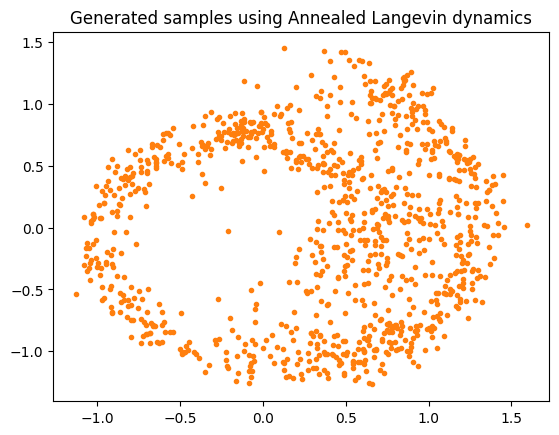

In [18]:
plt.plot(samples2[:, 0], samples2[:, 1], 'C1.')
plt.title('Generated samples using Annealed Langevin dynamics')